## Описание проекта

Нанимателем выступает компания "Ненужные вещи", у компании есть приложение где пользователи могут продавать и покупать вещи друг друга


Заказчик хочет определить, какая основная категория пользователей, какие есть с смежные категории, посмотреть на их различие в поведении по метрикам. 

Вопросы заказчика:
1. Какие пользователи склонны часто возвращаться в мобильное приложение?
2. Какие пользователи часто делают целевое событие (contacts_show)
3. Как различается время между распространенными событиями пользователей, (например, различаются ли пользователи по группам на основе времени, которое проходит с момента первого использования мобильного приложения и до использования функции поиска)?

Задачи
Выделить (отметить) группы пользователей, которые различаются по метрикам:
- Retantion Rate
- Время в приложении
- Частота совершения событий
- Конверсия в целевое действие CONTACTS_SHOW


Данная задача выполняется для прорабоки действий для повышения вовлечённости пользователей. В последствии выдвинуть гипотезы как можно оптимизировать пути пользователей, выдвинуть идеи для экспериментов

Отчёт должен быть представлен должно быть в виде дашборда и презентации

## Презентация

https://disk.yandex.ru/i/ht2T0dS-zACtfg

# 1. Изучение данных

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [3]:
mobile_sourсes.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [4]:
mobile_dataset.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [5]:
mobile_sourсes.columns = ['user_id','source']
mobile_dataset.columns = ['event_time','event_name','user_id']

In [6]:
mobile_sourсes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [7]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


В датафреймах нет отсутсвующих значений

In [8]:
display(len(mobile_sourсes.user_id.unique()))
display(len(mobile_dataset.user_id.unique()))

4293

4293

Уникальное количество пользователей ресурсов сопадает с количеством с количеством строк в mobile_sourсes и с уникальным количеством пользователей в mobile_dataset

In [9]:
display(mobile_sourсes.duplicated().sum())
display(mobile_dataset.event_time.duplicated().sum())

0

0

Дубликатов в значениях нет

In [10]:
set1 = set(mobile_sourсes.user_id)
set2 = set(mobile_dataset.user_id.unique())
print(len(set1&set2))

4293


ID уникальных пользователей в датафреймах совпадают, можем объеденить таблицы

In [11]:
df = mobile_dataset.merge(mobile_sourсes, on='user_id')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
 3   source      74197 non-null  object
dtypes: object(4)
memory usage: 2.8+ MB


Преобразуем типы данных

In [13]:
df['event_time'] = pd.to_datetime(df['event_time'])

In [14]:
print(df.event_time.max())
print(df.event_time.min())

2019-11-03 23:58:12.532487
2019-10-07 00:00:00.431357


In [15]:
print(df.event_time.max()-df.event_time.min())

27 days 23:58:12.101130


Выяснили что предоставлена выборка за временной промежуток около 28 дней 

т.к. события contacts_show и show_contacts заменим событие show_contacts событием contacts_show

In [16]:
df.event_name = df.event_name.replace('show_contacts','contacts_show')

# 2. Иследовательский анализ данных

### Обработка данных

Добавим столбец первого посещения каждого пользователя

In [17]:
first_visit = df.sort_values(by='event_time').groupby('user_id').agg({'event_time':'first'}).reset_index()
first_visit.columns = ['user_id','first_dt']
first_visit.head()

,user_id,first_dt
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364


Добавим столбец времени прошедшего с первого использования

In [18]:
df = df.merge(first_visit, on='user_id')
df['lifetime'] = df['event_time'] - df['first_dt']

Добавим столбец сессий, за сессию будем считать время проведённое пользователем в приложении в течении 60 минут, после окончания 60 минут, время проведённое в приложении будет считать, как за следующую сессию. 

In [19]:
df['session'] = df.groupby(['user_id',pd.Grouper(key='event_time',freq='60min')]).ngroup()+1
df.sort_values(by='session')


,event_time,event_name,user_id,source,first_dt,lifetime,session
2171,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:45.989359,0 days 00:00:00,1
2172,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:45.989359,0 days 00:00:45.063550,1
2173,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:45.989359,0 days 00:01:19.733130,1
2174,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:45.989359,0 days 00:03:34.746102,1
2175,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:45.989359,0 days 00:05:44.928143,1
...,...,...,...,...,...,...,...
19042,2019-11-03 15:37:43.995209,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-10-12 00:57:21.241896,22 days 14:40:22.753313,12431
19048,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-10-12 00:57:21.241896,22 days 14:54:02.717676,12431
19051,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-10-12 00:57:21.241896,22 days 15:10:56.960838,12432
19050,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-10-12 00:57:21.241896,22 days 15:10:19.690181,12432


Пронумеруем сессии для каждого отдельного пользователя

In [20]:
n = 0
for x in df.user_id.unique():
    sample = df[['event_time', 'user_id']].query('user_id == @x')
    sample['session'] = sample.groupby(['user_id',pd.Grouper(key='event_time',freq='60min')]).ngroup()+1
    sample_series = pd.Series(data=list(sample.session), index=sample.event_time)
    if n == 0:
        series = sample_series
    else:
        series = pd.concat([series, sample_series], axis=0)
    n = 1

In [21]:
sessions = pd.DataFrame({'event_time' : series.index, 'user_session' : series.values})
df = df.merge(sessions, on='event_time')

In [22]:
df = df.sort_values(by=['session', 'event_time'])

Введём в датафрейм df очерёдность событий в каждой сессии

In [23]:
sesion_list = df.session.tolist()

In [24]:
order = []
append_num = 0
list_num = 1
for n in sesion_list:
    if n == list_num:
        append_num += 1
        order.append(append_num)
    else:
        append_num = 1
        list_num += 1
        order.append(append_num)

In [25]:
df['action'] = order

Сгруппируем пользователей по частоте использования приложения

In [26]:
max_ses = df.groupby('user_id').agg({'user_session' : 'max', 'event_time' : 'count'})

In [27]:
np.percentile(max_ses.sort_values(by='user_session').user_session.to_list(), list(range(1,101)))

array([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   2.,   2.,   2.,   2.,   2.,
         2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
         2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
         2.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,
         3.,   3.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   5.,   5.,
         5.,   5.,   6.,   6.,   7.,   7.,   8.,   9.,  11.,  14.,  19.,
       113.])

In [28]:
np.percentile(max_ses.sort_values(by='user_session').user_session.to_list(), [0,50,90,100])

array([  1.,   2.,   5., 113.])

In [29]:
np.percentile(max_ses.sort_values(by='event_time').event_time.to_list(), list(range(1,101)))

array([  1.  ,   2.  ,   2.  ,   3.  ,   3.  ,   3.  ,   4.  ,   4.  ,
         4.  ,   4.  ,   4.  ,   4.  ,   4.  ,   4.  ,   4.  ,   5.  ,
         5.  ,   5.  ,   5.  ,   5.  ,   5.  ,   5.  ,   5.  ,   5.  ,
         5.  ,   5.  ,   6.  ,   6.  ,   6.  ,   6.  ,   6.  ,   6.  ,
         6.  ,   6.  ,   6.  ,   7.  ,   7.  ,   7.  ,   7.  ,   7.  ,
         7.  ,   8.  ,   8.  ,   8.  ,   8.  ,   8.  ,   8.  ,   9.  ,
         9.  ,   9.  ,   9.  ,   9.  ,  10.  ,  10.  ,  10.  ,  10.  ,
        11.  ,  11.  ,  11.  ,  11.  ,  12.  ,  12.  ,  12.  ,  13.  ,
        13.  ,  13.  ,  14.  ,  14.  ,  15.  ,  15.  ,  15.  ,  16.  ,
        16.  ,  17.  ,  17.  ,  18.  ,  18.84,  19.  ,  20.  ,  21.  ,
        22.  ,  23.  ,  24.  ,  25.  ,  26.  ,  28.  ,  29.  ,  31.  ,
        33.  ,  36.  ,  39.  ,  42.  ,  45.  ,  51.  ,  59.  ,  65.32,
        76.24,  95.16, 132.  , 478.  ])

In [30]:
total_session_labels = ['редко', 'средне', 'очень часто']
max_ses['session_group'] = pd.qcut(max_ses['user_session'],
                              q=[0, .5, .9, 1],
                              labels=total_session_labels)


In [31]:
max_ses = max_ses.reset_index()
df = df.merge(max_ses[['user_id','session_group']], on='user_id')

Сгруппируем пользователей по количеству действий за одну сессию

In [32]:
med_act = df.groupby('user_id').agg({'action' : 'median'})

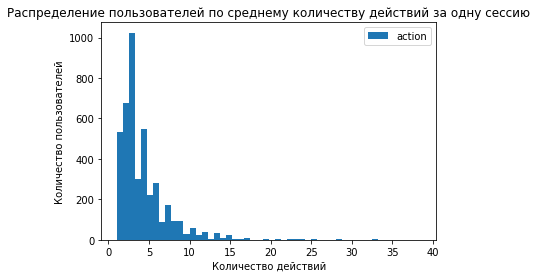

In [33]:
med_act.plot(kind='hist', bins=50)
plt.title('Распределение пользователей по среднему количеству действий за одну сессию')
plt.xlabel('Количество действий')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

In [34]:
np.percentile(med_act.action.tolist(), list(range(1,101)))

array([ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.5 ,  1.5 ,  1.5 ,
        1.5 ,  1.5 ,  1.5 ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ,
        2.5 ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,
        3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.5 ,  3.5 ,
        3.5 ,  3.5 ,  3.5 ,  3.5 ,  3.5 ,  4.  ,  4.  ,  4.  ,  4.  ,
        4.  ,  4.  ,  4.  ,  4.  ,  4.5 ,  4.5 ,  4.5 ,  4.5 ,  5.  ,
        5.  ,  5.  ,  5.  ,  5.  ,  5.5 ,  5.5 ,  5.5 ,  6.  ,  6.  ,
        6.  ,  6.  ,  6.5 ,  6.5 ,  7.  ,  7.  ,  7.  ,  7.5 ,  8.  ,
        8.  ,  8.5 ,  9.  ,  9.5 , 10.  , 11.  , 12.  , 13.5 , 15.54,
       38.5 ])

In [35]:
np.percentile(med_act.action.tolist(),[1,30,50, 75, 100])

array([ 1. ,  2.5,  3. ,  5. , 38.5])

In [36]:
total_action_labels = ['мало', 'среднее', 'больше среднего', 'много']
med_act['action_group'] = pd.qcut(med_act['action'],
                              q=[0, .3, .6, .9, 1],
                              labels=total_action_labels)

In [37]:
med_act.groupby('action_group').agg({'action': 'max'})

,action
action_group,
мало,2.5
среднее,4.0
больше среднего,8.0
много,38.5


In [38]:
med_act.groupby('action_group').agg({'action': 'count'})

,action
action_group,
мало,1619
среднее,1280
больше среднего,1039
много,355


In [39]:
med_act = med_act.reset_index()
df = df.merge(med_act[['user_id','action_group']], on='user_id')

Создадим столбец с количеством совершонных целевых действий каждым пользователем за период

In [40]:
df_con_show = df.query('event_name == "contacts_show"')
df_con_show  = df_con_show.pivot_table(index='user_id', values='event_name', aggfunc='count').reset_index()\
.rename(columns={'event_name' : 'contacts_show_count'})

df = df.merge(df_con_show, on='user_id', how='left')
df.contacts_show_count = df.contacts_show_count.fillna(0)

Создадим столбец обозначающий факт совершонния целевого действия каждым пользователем за период

In [41]:
df['contacts_show_true'] = (df.contacts_show_count > 0)*1

Создадим столбец значение которого будет 1 при event_name == contacts_show

In [42]:
df['event_contacts_show'] = (df.event_name == 'contacts_show')*1

Создадим столбец обозначающий факт показа рекомендации пользователю за всё время

In [43]:
df_tips_show = df.query('event_name == "tips_show"')
df_tips_show  = df_tips_show.pivot_table(index='user_id', values='event_name', aggfunc='count').reset_index()\
.rename(columns={'event_name' : 'tips_show_true'})

df = df.merge(df_tips_show, on='user_id', how='left')
df.tips_show_true = df.tips_show_true.fillna(0)
df['tips_show_true'] = (df.tips_show_true > 0)*1

Создадим столбец значение которого будет 1 при event_name == tips_show

In [44]:
df['event_tips_show'] = (df.event_name == 'tips_show')*1

Создадим столбец обозначающий факт добавление в избранное пользователем за всё время

In [45]:
df_favorit = df.query('event_name == "favorites_add"')
df_favorit  = df_favorit.pivot_table(index='user_id', values='event_name', aggfunc='count').reset_index()\
.rename(columns={'event_name' : 'favorit_true'})

df = df.merge(df_favorit, on='user_id', how='left')
df.favorit_true = df.favorit_true.fillna(0)
df['favorit_true'] = (df.favorit_true > 0)*1

Создадим столбец обозначающий факт совершения события  map пользователем за всё время

In [46]:
df_map = df.query('event_name == "map"')
df_map  = df_map.pivot_table(index='user_id', values='event_name', aggfunc='count').reset_index()\
.rename(columns={'event_name' : 'map_true'})

df = df.merge(df_map, on='user_id', how='left')
df['map_true'] = df['map_true'].fillna(0)
df['map_true'] = (df.map_true > 0)*1

In [47]:
# Факт использования map  в данную сессию
df['event_map'] = (df.event_name == 'map')*1

##### Разделим пользователей на  до и после использования фукции map

In [48]:
# отберём пользователей только которые пользовались map
map_df = df.query('map_true == 1') 

In [49]:
# первое использование ф-и map каждым пользователем
fuse_map = map_df.query('event_map == 1').sort_values(by=['user_id', 'event_time'])\
.groupby('user_id').agg({'event_time': 'first'}).reset_index()

In [50]:
bef_map = []
aft_map = []
for n in range(len(fuse_map)):
    user = fuse_map.iloc[n,0]
    time = fuse_map.iloc[n,1]
    if n == 0:
        bef_map = map_df.query('user_id == @user & event_time < @time')
        aft_map = map_df.query('user_id == @user & event_time >= @time')
    else:
        bef_map = bef_map.append(map_df.query('user_id == @user & event_time < @time'))
        aft_map = aft_map.append(map_df.query('user_id == @user & event_time >= @time'))
    

    

In [51]:
# Проверка
len(aft_map)+len(bef_map) == len(map_df) 

True

In [52]:
aft_map = aft_map[['event_time', 'user_id']]
aft_map['use_map'] = 'after'

map_df = map_df.merge(aft_map, on='event_time', how='left')
map_df['use_map'] = map_df['use_map'].fillna('before')

##### Разделим пользователей на  до и после показа им рекламного объявдения

In [53]:
# отберём пользователей только которые показывались рекомендации
tip_df = df.query('tips_show_true == 1') 

In [54]:
# первое показ tip каждому пользователю
fuse_tips = tip_df.query('event_tips_show == 1').sort_values(by=['user_id', 'event_time'])\
.groupby('user_id').agg({'event_time': 'first'}).reset_index()

In [55]:
bef_tip = []
aft_tip = []
for n in range(len(fuse_tips)):
    user = fuse_tips.iloc[n,0]
    time = fuse_tips.iloc[n,1]
    if n == 0:
        bef_tip = tip_df.query('user_id == @user & event_time < @time')
        aft_tip = tip_df.query('user_id == @user & event_time >= @time')
    else:
        bef_tip = bef_tip.append(tip_df.query('user_id == @user & event_time < @time'))
        aft_tip = aft_tip.append(tip_df.query('user_id == @user & event_time >= @time'))
    

    

In [56]:
# Проверка
len(bef_tip)+len(aft_tip) == len(tip_df) 

True

In [57]:
aft_tip = aft_tip[['event_time', 'user_id']]
aft_tip['show_tip'] = 'after'

tip_df = tip_df.merge(aft_tip, on='event_time', how='left')
tip_df['show_tip'] = tip_df['show_tip'].fillna('before')

### Иследовательский анализ

In [58]:
df.lifetime.describe()

count                        74197
mean     2 days 21:11:42.647380391
std      5 days 04:37:04.793688216
min                0 days 00:00:00
25%         0 days 00:07:27.545680
50%         0 days 01:05:36.289853
75%         3 days 09:58:55.275615
max        26 days 20:45:24.186129
Name: lifetime, dtype: object

##### Посмотрим с каких ресурсов в большинстве приходят пользователи

Сначало убедимся что каждый пользователь приходит только с одного определённого ресурса

In [59]:
df.pivot_table(index='user_id', values='source', aggfunc='nunique').source.max()

1

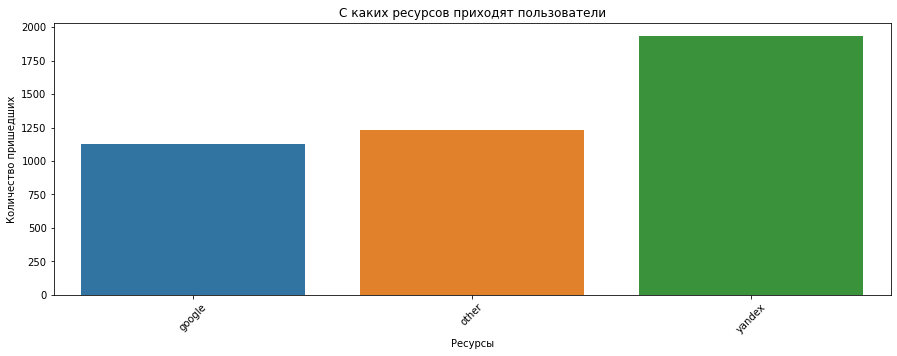

In [60]:
source_count = df.groupby('user_id', as_index=False).agg({'source' : 'first'})\
.pivot_table(index='source', values='user_id', aggfunc='count').reset_index()
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.barplot(x='source', y='user_id', data=source_count)

plt.xlabel('Ресурсы')
plt.ylabel('Количество пришедших')
plt.title('С каких ресурсов приходят пользователи')

plt.show()

- В большинстве случаев пользователи приходят с яндекса, с гугла приходит меньше примерно в 1.5 раза,с остальных ресурсов вместе взятых приходит примерно столько же как с гугла

##### Посмотрим какие события совершаются чаще всего в одну сессию 

In [61]:
events_count = df.pivot_table(index='event_name', values='user_id', aggfunc='count').reset_index()
# events_count

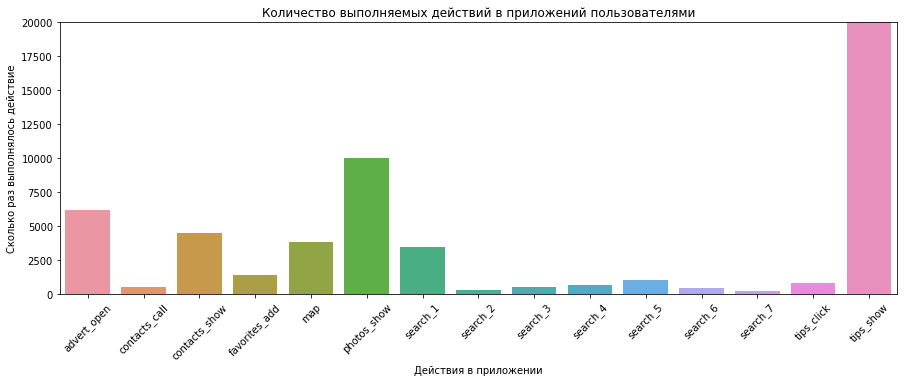

In [62]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.barplot(x='event_name', y='user_id', data=events_count)
plt.ylim((0, 20000))
plt.xlabel('Действия в приложении')
plt.ylabel('Сколько раз выполнялось действие')
plt.title('Количество выполняемых действий в приложений пользователями')

plt.show()

- По частоте событий, лидирует tips_show, потом идёт photos_show, затем advert_open и contacts_show 
- Достаточно редки события tips_click, contacts_call, favorites_add, все события search (кроме search_1) 

##### Посмотрим сколько событий совершается в одну сессию

In [63]:
print('Среднее количество событий в сессии: ' + str(df.groupby('session')['event_time'].count().mean()))
print('Медианное количество событий в сессии: ' + str(df.groupby('session')['event_time'].count().median()))

Среднее количество событий в сессии: 5.968227155727155
Медианное количество событий в сессии: 4.0


##### Посмотрим какие действия в сессиях повторяются чаще всего

In [64]:
ses = df.pivot_table(index='session', columns='event_name',values='event_time', aggfunc='count').reset_index()
ses = ses.fillna(0)


In [65]:
for x in ses.columns:
    ses[x] = ses[x].astype('int')

In [66]:
ses_list = []
for x in ses.values:
    ses_list.append(list((x[1:]>0)*1))

In [67]:
df_ses = pd.DataFrame(data=ses_list, columns=ses.columns[1:])

In [68]:
ses_uniq = df_ses.groupby(df_ses.columns.tolist(), as_index=False).size().sort_values(by='size', ascending=False)


Как мы видим есть множество сессий с одним событием, добавим столбец с количеством событий, за сессию

In [69]:
ses_uniq['act_count'] = ses_uniq.drop(columns = ['size']).sum(axis=1)

In [70]:
ses_uniq.head(60)

,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show,size,act_count
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3606,1
57,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1558,1
63,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,870,2
55,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,700,1
60,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,675,2
131,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,566,2
221,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,309,3
199,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,296,2
130,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,259,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,207,2


Самые частые сессии:
- Показанные рекомендации
- Посмотр фотографий в объявлении
- Показанные рекомендаци + открытие карты объявлений 
- search_1
- search_1 + photos_show

##### Посморим в какие действия в приложении совместны с просмотром контакта

In [71]:
df_ses['act_count'] = df_ses.sum(axis=1)

Проверим что звонок контакту, перед этим сопровождается его просмотром

In [72]:
con_call = df_ses.query('contacts_call == 1')
con_call.sum()

event_name
advert_open       16
contacts_call    325
contacts_show    323
favorites_add     18
map                0
photos_show      117
search_1         106
search_2           0
search_3           0
search_4           0
search_5           0
search_6           0
search_7           0
tips_click         0
tips_show          0
act_count        905
dtype: int64

Только 2 раза звонок контакту не сопровождался его просмотром (связано скорее, что просмотр был выполнен в предыдущую сессию), данной неточностью можно пренебречь

In [73]:
con_show = df_ses.query('contacts_show == 1')
con_not_show = df_ses.query('contacts_show != 1')
pd.DataFrame({'contacts_show_true' : (con_show.sum()/con_show.shape[0]) * 100,
              'contacts_show_false' : (con_not_show.sum()/con_not_show.shape[0]) * 100,
             'contacts_show_all' : (df_ses.sum()/df_ses.shape[0]) * 100})

,contacts_show_true,contacts_show_false,contacts_show_all
event_name,,,
advert_open,7.028424,12.355911,11.526705
contacts_call,16.692506,0.019053,2.614221
contacts_show,100.000000,0.000000,15.564672
favorites_add,5.633075,4.163094,4.391892
map,14.160207,19.300753,18.500644
photos_show,18.294574,23.540059,22.723616
search_1,12.661499,14.480328,14.197233
search_2,1.705426,2.638849,2.493565
search_3,1.395349,2.743641,2.533784


 - в сессии в которых показывался контакт можно выделить, что пользователи чаще на 1,5 процентра нажимали на рекомендованные объявления и чаще добавляли в избранное в 1,5 раза.
 - так же можно отметить в сессии где совершался просмотр контакта, остальных действий совершалось меньше
 - самое болшое количество действий в сессию в среднем в сессиях где выполнялось целевое действие 

In [74]:
for x in df_ses.columns:
    print(x, df_ses['contacts_show'].corr(df_ses[x]))
    

advert_open -0.06047777731685479
contacts_call 0.3788250520536201
contacts_show 0.9999999999999999
favorites_add 0.026005819089376884
map -0.047992217167937716
photos_show -0.045379075744237704
search_1 -0.018891717910565486
search_2 -0.021701188496482775
search_3 -0.031103142888399975
search_4 -0.05048318388742331
search_5 -0.05843330102670067
search_6 -0.04221197122827764
search_7 -0.03938348891039036
tips_click 0.02599844802437486
tips_show -0.07621064518744955
act_count 0.274144476862168


- Коэфициент корреляции между просмотра контактов и других действий зависимости не показывает

##### Посмотрим на количество пользователей (%) совершивших целевое действие, в зависимости от количества сессий у пользователя

In [75]:
contacts_show_true = df.groupby('user_id', as_index=False).agg({'contacts_show_true' : 'first'})
session_group = df.groupby('user_id', as_index=False).agg({'session_group' : 'first'})
contacts_show_true = contacts_show_true.merge(session_group, on='user_id')

In [76]:
contacts_show_true.head()

,user_id,contacts_show_true,session_group
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,средне
1,00157779-810c-4498-9e05-a1e9e3cedf93,1,очень часто
2,00463033-5717-4bf1-91b4-09183923b9df,0,редко
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,0,очень часто
4,00551e79-152e-4441-9cf7-565d7eb04090,1,средне


In [77]:
contacts_show_true.pivot_table(index='session_group', values='contacts_show_true', aggfunc='sum')\
/contacts_show_true.pivot_table(index='session_group', values='contacts_show_true', aggfunc='count')

,contacts_show_true
session_group,
очень часто,0.502451
редко,0.160248
средне,0.317298


##### Посмотрим на среднее количество целевых действия на одного пользователя, в зависимости от количества сессий у пользователя

In [78]:
contacts_show_count = df.groupby('user_id', as_index=False).agg({'contacts_show_count' : 'first'})
contacts_show_count = contacts_show_count.merge(session_group, on='user_id')

In [79]:
contacts_show_count.pivot_table(index='session_group', values='contacts_show_count', aggfunc='sum')\
/contacts_show_count.pivot_table(index='session_group', values='contacts_show_count', aggfunc='count')

,contacts_show_count
session_group,
очень часто,4.919118
редко,0.446699
средне,1.251791


- У пользователей у которых большое количество сессий чаще и больше целевых действий

##### Посмотрим на количество пользователей (%) совершивших целевое действие, в зависимости от ресурса с которого пришёл пользователь

In [80]:
source_name = df.groupby('user_id', as_index=False).agg({'source' : 'first'})
source_true = contacts_show_true.merge(source_name, on='user_id')

In [81]:
source_true.pivot_table(index='source', values='contacts_show_true', aggfunc='sum')\
/source_true.pivot_table(index='source', values='contacts_show_true', aggfunc='count')

,contacts_show_true
source,
google,0.243578
other,0.185366
yandex,0.247156


##### Посмотрим среднее на количество пользователей совершивших целевое действие, в зависимости от ресурса с которого пришёл пользователь

In [82]:
source_count = contacts_show_count.merge(source_name, on='user_id')

In [83]:
source_count.pivot_table(index='source', values='contacts_show_count', aggfunc='sum')\
/source_count.pivot_table(index='source', values='contacts_show_count', aggfunc='count')

,contacts_show_count
source,
google,1.275465
other,0.856911
yandex,1.052223


- количество пользователей совершивших целевые действия у гугла и яндекса больше чем с остальных ресурсов и одинаков, но с гугла пользователь в среднем больше совершает целевых действий. 

##### Посмотрим в какую из сессий чаще совершается целевое действие

In [84]:
ceil_ses = df.pivot_table(index='user_session', columns='session_group', values='event_contacts_show', aggfunc='sum')\
/df.pivot_table(index='user_session', columns='session_group', values='event_contacts_show', aggfunc='count')
# ceil_ses.reset_index()
ceil_ses.head(5)

session_group,редко,средне,очень часто
user_session,,,
1,0.043032,0.055535,0.054875
2,0.056023,0.060915,0.047813
3,NaN,0.076699,0.065487
4,NaN,0.064771,0.056604
5,NaN,0.049942,0.049827


In [85]:
ceil_ses.columns = ['редко', 'средне', 'очень_часто']

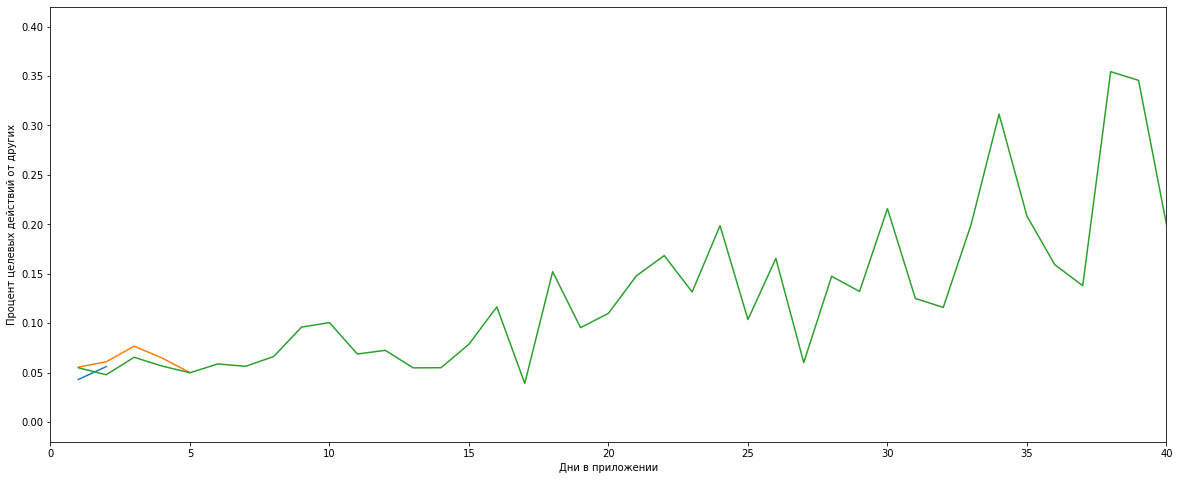

In [86]:
plt.figure(figsize=(20,8))
plt.xlabel('Дни в приложении')
plt.ylabel('Процент целевых действий от других')
plt.plot(ceil_ses)
plt.xlim(0,40)
plt.show()

- Пользователи у которых мало сессий совершают чаще целевое действие в первую сессию
- Пользователи у которых 3-5 сессий чаще совершают целевое действие на 3 сессию
- Пользователи с большим количеством сессий совершают больше целевых действий по мере роста сессий до 38

##### Посмотрим каким действием в сессии чаще совершается событие

In [87]:
ceil_act = df.pivot_table(index='action', values='event_contacts_show', aggfunc='sum')\
/df.pivot_table(index='action', values='event_contacts_show', aggfunc='count')


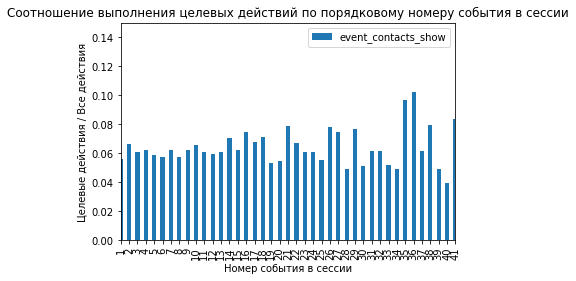

In [88]:
ceil_act.plot(kind='bar')
plt.xlim(0,40)
plt.ylim(0,0.15)
plt.title('Соотношение выполнения целевых действий по порядковому номеру события в сессии')
plt.xlabel('Номер события в сессии')
plt.ylabel('Целевые действия / Все действия')
plt.show()

- целевое событие может совершаться как и сначало сессии так и ближе концу (зависимости нет)

##### Посмотрим на разницу между группами где совершалось целевое действие и где не совершалось

In [89]:
df_true = df.query('contacts_show_true == 1')
df_false = df.query('contacts_show_true == 0')

In [90]:
def session_event(df, event, bool=True):
    ses = df.pivot_table(index='session', columns='event_name',values='event_time', aggfunc='count').reset_index()
    ses = ses.fillna(0)


    for x in ses.columns:
        ses[x] = ses[x].astype('int')

    ses_list = []
    for x in ses.values:
        ses_list.append(list((x[1:]>0)*1))

    df_ses = pd.DataFrame(data=ses_list, columns=ses.columns[1:])
    df_ses['act_count'] = df_ses.sum(axis=1)
    if bool:
        con_show = df_ses[df_ses[event] == 1]
        con_not_show = df_ses[df_ses[event] != 1]

        return pd.DataFrame({f'{event}_true' : (con_show.sum()/con_show.shape[0]) * 100,
                      f'{event}_false' : (con_not_show.sum()/con_not_show.shape[0]) * 100,
                     f'{event}_true_group' : (df_ses.sum()/df_ses.shape[0]) * 100})
    else:
        return pd.DataFrame({f'{event}_false_group' : (df_ses.sum()/df_ses.shape[0]) * 100})

In [91]:
table_ft_show = session_event(df_true, 'contacts_show')
table_ft_show['contacts_show_false_group'] = session_event(df_false,'contacts_show', False)['contacts_show_false_group']

In [92]:
table_ft_show

,contacts_show_true,contacts_show_false,contacts_show_true_group,contacts_show_false_group
event_name,,,,
advert_open,7.028424,9.966405,8.734287,13.174725
contacts_call,16.692506,0.074655,7.043780,NaN
contacts_show,100.000000,0.000000,41.937581,NaN
favorites_add,5.633075,4.031355,4.703078,4.208237
map,14.160207,13.960433,14.044213,21.130724
photos_show,18.294574,30.085853,25.140876,21.297007
search_1,12.661499,15.938783,14.564369,13.980558
search_2,1.705426,2.239642,2.015605,2.775646
search_3,1.395349,2.650243,2.123971,2.775646


In [93]:
table_ft_show.columns = ['Сессии группы которая смотрела контакт, в сессии был просмотр',
                         'Сессии группы которая смотрела контакт, в сессиях просмотра не было',
                         'Все сессии группы смотревшая контакт',
                         'Все сессии группы несмотревшая контакт']

- группа которая совершала целевое действие чаще добавляла товар в избранное (но отличие не сильно существенное)
- группа которая совершала целевое действие чаще смотрела фотографии (но фотографии чаще просматривались не в ту сессию когда совершлось целевое действие)
- группа которая совершала целевое действие чаще нажимала на просмотр рекомендации (данное действие чаще совершалось в момент совершения целевого действия)
- группа которая несовершала целевое действие больше всего видела рекомендаций

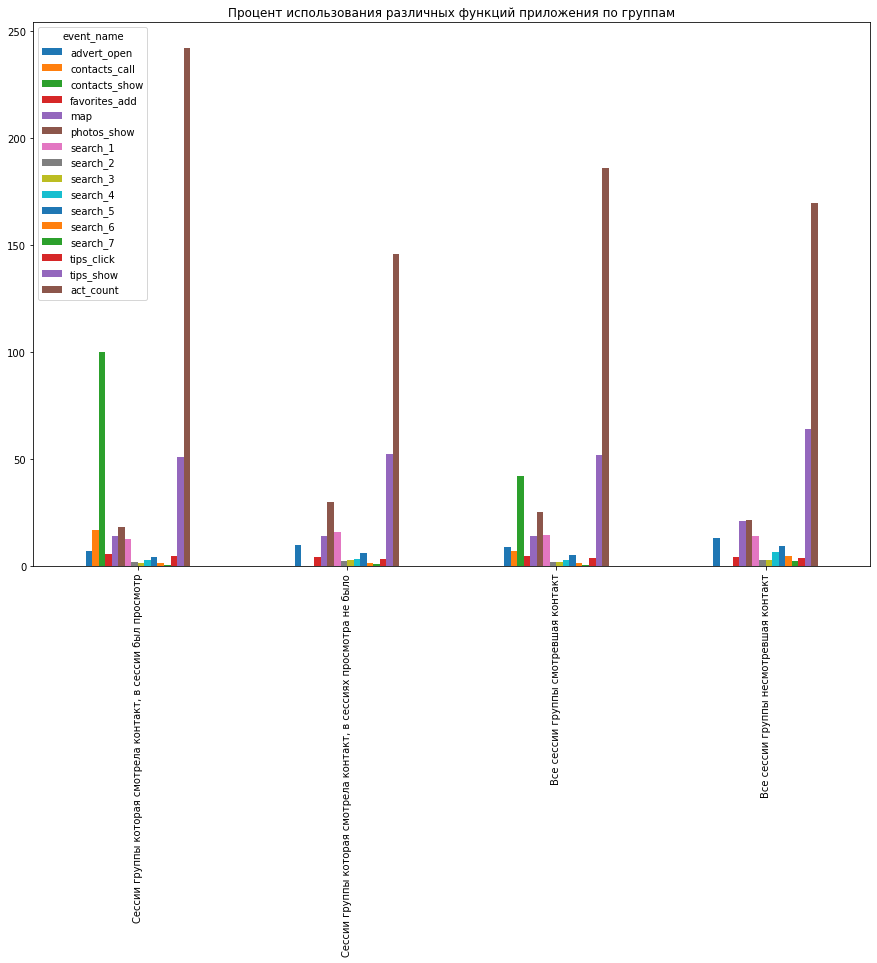

In [94]:
table_ft_show.T.plot.bar(figsize=(15,10))
plt.title('Процент использования различных функций приложения по группам')
plt.show()

In [95]:
df_tips_true = df.query('tips_show_true == 1')
df_tips_false = df.query('tips_show_true == 0')

In [96]:
table_ft_tips = session_event(df_tips_true, 'tips_show')
table_ft_tips['tips_show_false_group'] = session_event(df_tips_false,'tips_show', False)['tips_show_false_group']

In [97]:
table_ft_tips

,tips_show_true,tips_show_false,tips_show_true_group,tips_show_false_group
event_name,,,,
advert_open,13.896016,18.373494,14.264469,6.463443
contacts_call,0.000000,0.150602,0.012393,7.426083
contacts_show,13.288319,16.867470,13.582848,19.229888
favorites_add,2.201215,4.216867,2.367084,8.136603
map,26.090479,37.198795,27.004585,2.773321
photos_show,0.094531,13.102410,1.164952,62.594545
search_1,0.054018,4.668675,0.433759,39.651616
search_2,3.119514,4.518072,3.234602,1.123080
search_3,3.592167,4.216867,3.643574,0.481320


- по зависимости показа рекомендательных объявлений видим, что группа которым объявление показывалось реже выполняли целевое действие.
- группа которым не показывались рекомендованные объявления так же, намного чаще смотрят фотографии, и выполняет в среднем меньше действий

In [98]:
table_ft_tips.columns = ['Сессии группы которой показывались рекомендации, в сессии была рекомендация',
                         'Сессии группы которой показывались рекомендации, в сессиях не было рекомендации',
                         'Все сессии группы которой показывались рекомендации',
                         'Все сессии группы которой непоказывались рекомендации']

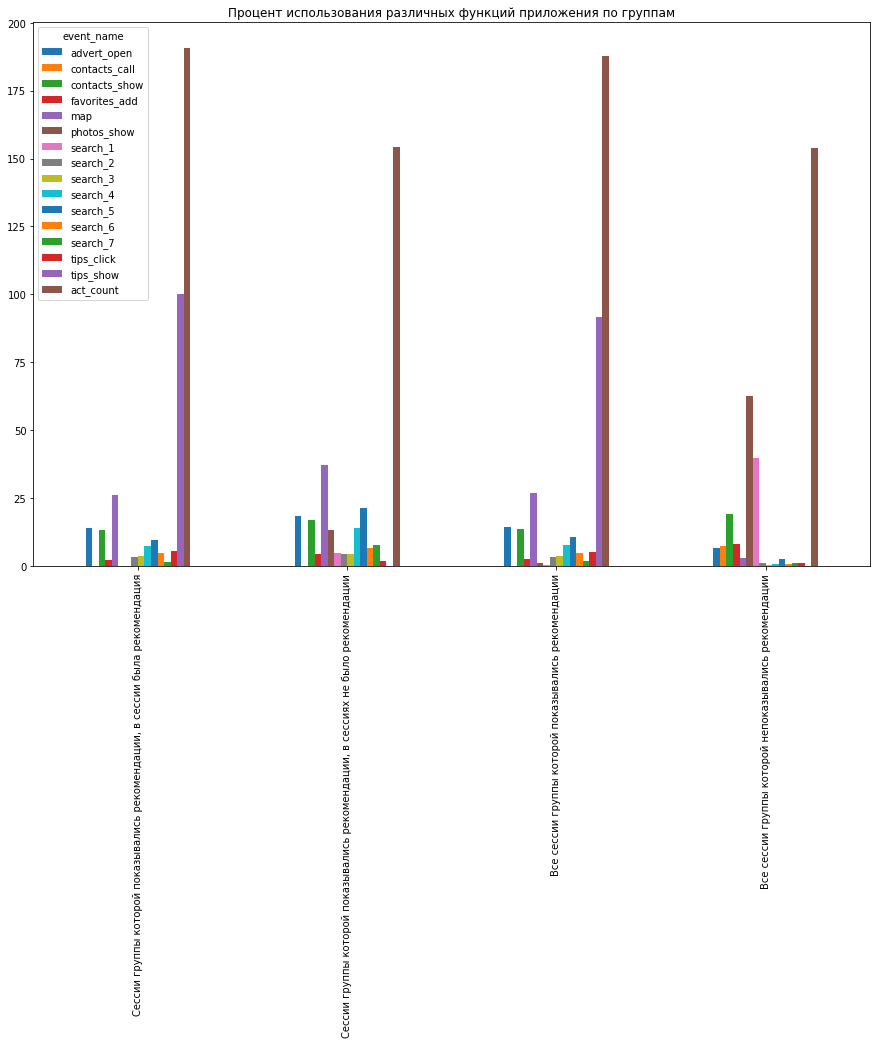

In [99]:
table_ft_tips.T.plot.bar(figsize=(15,10))
plt.title('Процент использования различных функций приложения по группам')
plt.show()

##### Попоробуем разделить группы по источникам и по тому насколько часто используются ими приложении

In [100]:
source_session_group = df.groupby('user_id', as_index=False)\
.agg({'source': 'first', 'session_group': 'first', 'contacts_show_count': 'first', 'contacts_show_true': 'first' })

In [101]:
source_session_group.pivot_table(index='source', values='contacts_show_count', aggfunc='mean')['contacts_show_count']

source
google    1.275465
other     0.856911
yandex    1.052223
Name: contacts_show_count, dtype: float64

In [102]:
source_session_group_count = source_session_group.pivot_table(
    index='source', columns='session_group', values='user_id', aggfunc='count')
source_session_group_count.columns = ['редко','средне','очень часто']
source_session_group_count = source_session_group_count.div(source_session_group_count.sum(axis=1), axis=0)

# Количество событий в процентах (процент по ресурсам)
source_session_group_count

,редко,средне,очень часто
source,,,
google,0.093003,0.687334,0.219663
other,0.097561,0.661789,0.240650
yandex,0.094623,0.681489,0.223888


In [103]:
source_session_group_count = source_session_group.pivot_table(
    index='source', columns='session_group', values='contacts_show_count', aggfunc='mean')
source_session_group_count.columns = ['редко','средне','очень часто']
source_session_group_count['общее'] = source_session_group.pivot_table(
    index='source', values='contacts_show_count', aggfunc='mean')['contacts_show_count']

# Среднее количество действий целевых действий на 1 человека
source_session_group_count

,редко,средне,очень часто,общее
source,,,,
google,7.504762,0.481959,1.120968,1.275465
other,4.608333,0.256757,0.986486,0.856911
yandex,3.639344,0.543247,1.508083,1.052223


In [104]:
source_session_group_count = source_session_group.pivot_table(
    index='source', columns='session_group', values='contacts_show_true', aggfunc='mean')
source_session_group_count.columns = ['редко','средне','очень часто']
source_session_group_count['общее'] = source_session_group.pivot_table(
    index='source', values='contacts_show_true', aggfunc='mean')['contacts_show_true']

# Процент совершиших целевое действие
source_session_group_count

,редко,средне,очень часто,общее
source,,,,
google,0.552381,0.175258,0.326613,0.243578
other,0.466667,0.109337,0.280405,0.185366
yandex,0.497268,0.182853,0.337182,0.247156


In [105]:
source_session_group_count = source_session_group.pivot_table(
    index='source', columns='session_group', values='contacts_show_count', aggfunc='sum')
source_session_group_count.columns = ['редко','средне','очень часто']
source_session_group_count['общее количество'] = source_session_group_count.sum(axis=1)

# Общее количество целевых действий
source_session_group_count

,редко,средне,очень часто,общее количество
source,,,,
google,788.0,374.0,278.0,1440.0
other,553.0,209.0,292.0,1054.0
yandex,666.0,716.0,653.0,2035.0


- самое большое количество целевых действий у яндекса, данный показатель достиг такого уровня за счёт самой большой аудитории у сервиса. 
- у гугл большу средних количеств действий по группе у которых много сессий, за счёт данного показателя у гугл лучше общие показатели по количеству целевых действий на одного человека

# 4. Основная цель иследования

#####  Конверсия (Conversion)

In [106]:
max_date = datetime(2019, 10, 20).date()

In [107]:
ss = df.copy()
ss = ss.query('first_dt <= @max_date')

In [108]:
ss['first_dt'] = ss['first_dt'].dt.date
ss['lifetime'] = ss['lifetime'].dt.days

In [109]:
ss = ss.query('lifetime <= 14')

In [110]:
def conversion(df, group):
    conv_df = df.sort_values(by=['user_id','event_contacts_show', 'event_time']).query('event_contacts_show == 1')\
    [['user_id', 'event_contacts_show', 'lifetime', 'event_time', group]]
    conv_df = conv_df.groupby('user_id', as_index=False).agg({'lifetime':'first', group:'first'})
    conv_df = conv_df.pivot_table(index=group, columns='lifetime', values='user_id',aggfunc='count').fillna(0)
    conv_df = conv_df.cumsum(axis=1)
    
    group_indate = df.groupby('user_id', as_index=False).agg({group:'first'})\
    .pivot_table(index=group, values='user_id', aggfunc='count')
    
    conv_df = conv_df.div(group_indate.values, axis=0)
    conv_df.columns = list(range(1,len(conv_df.columns) +1))
      
    return conv_df

##### Retantion

In [111]:
ss.groupby('user_id').agg({'lifetime' : 'max'}).describe()

,lifetime
count,2152.000000
mean,2.598048
std,4.347489
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,14.000000


- В большинстве случаев у пользователи уходят с приложения после первого использования, создадим ф-ю retantion rate

In [112]:
def retantion(df, group):
    ret_df = df.sort_values(by=['user_id','event_time']).groupby('user_id')\
    .agg({group:'first', 'lifetime':'max'}).reset_index()
    ret_df = ret_df.pivot_table(index=group, columns='lifetime', values='user_id', aggfunc='count').fillna(0)
    # т.к. пользователи не заходят каждый день, будем считать, что если пользователь заходил к примеру в 8 лайфтайм,
    # то он был пользователем и во все предыдущие лайфтаймы
    ret_df = ret_df[ret_df.columns.tolist()[::-1]]
    ret_df = ret_df.cumsum(axis=1)
    ret_df = ret_df[ret_df.columns.tolist()[::-1]]
    ret_df.columns = list(range(1,len(ret_df.columns) +1))

    group_indate = df.groupby('user_id',as_index=False).agg({group:'first'})\
    .pivot_table(index=group, values='user_id', aggfunc='count')

    ret_df = ret_df.div(group_indate.values, axis=0) * 100
    

    return ret_df


In [113]:
def ret_con_watch(df, group):
    ret = retantion(df, group)
    con = conversion(df, group)
    retT = ret.T
    conT = con.T
    
    ax1 = plt.subplot(1,2,1)
    retT.plot(figsize=(20,8), ax=ax1)
    plt.title('График оставшихся пользователей по дням')
    plt.ylabel('Процент оставшихся пользователей')
    plt.xlabel('Дней пользования приложением')
    plt.legend()

    ax2 = plt.subplot(1,2,2)
    plt.title('График коверсии пользователей по дням в приложении')
    conT.plot(ax=ax2)
    plt.ylabel('Процент пользователей посмотревших номер ')
    plt.xlabel('Дней пользования приложением')
    plt.legend()
    plt.show()

    

In [114]:
def ret_watch(df, group):
    ret = retantion(df, group)
    retT = ret.T
    
    retT.plot(figsize=(20,8))
    plt.title('График оставшихся пользователей по дням')
    plt.ylabel('Процент оставшихся пользователей')
    plt.xlabel('Дней пользования приложением')
    plt.legend()

first_dt


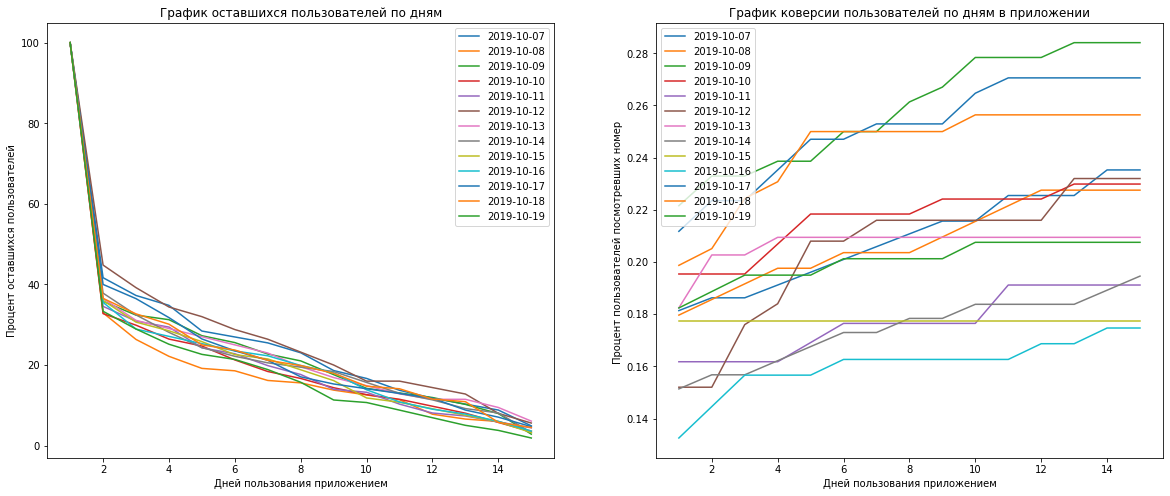

source


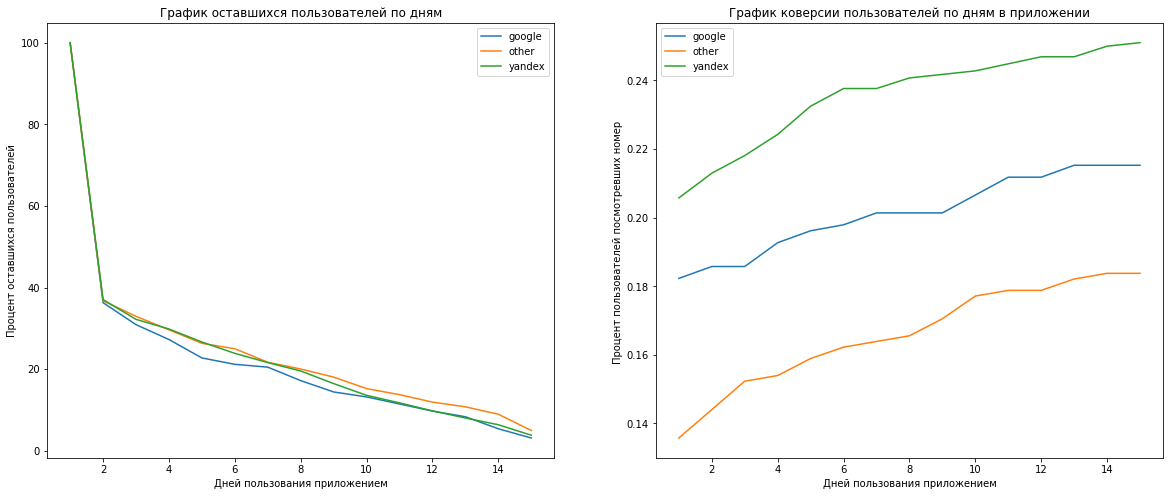

session_group


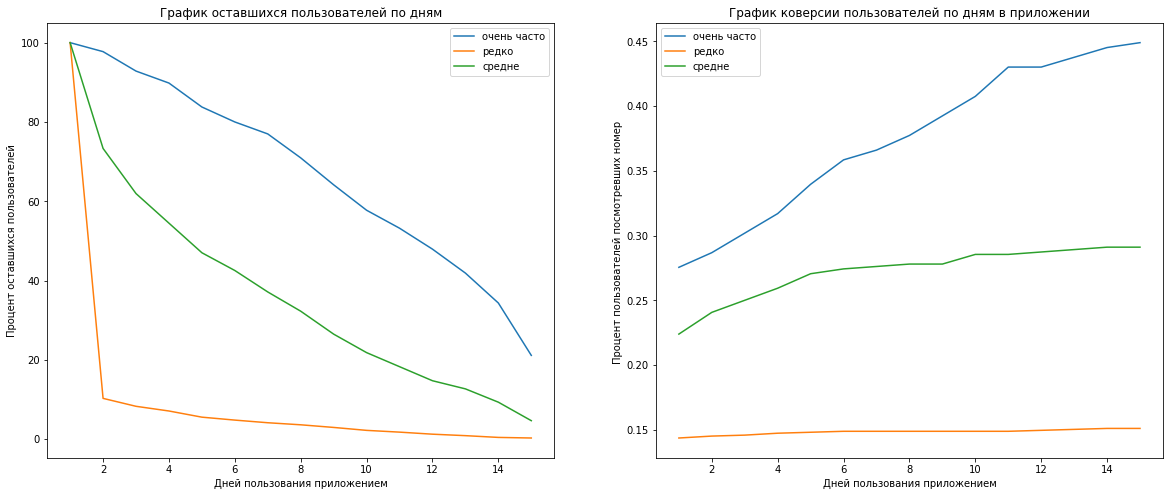

action_group


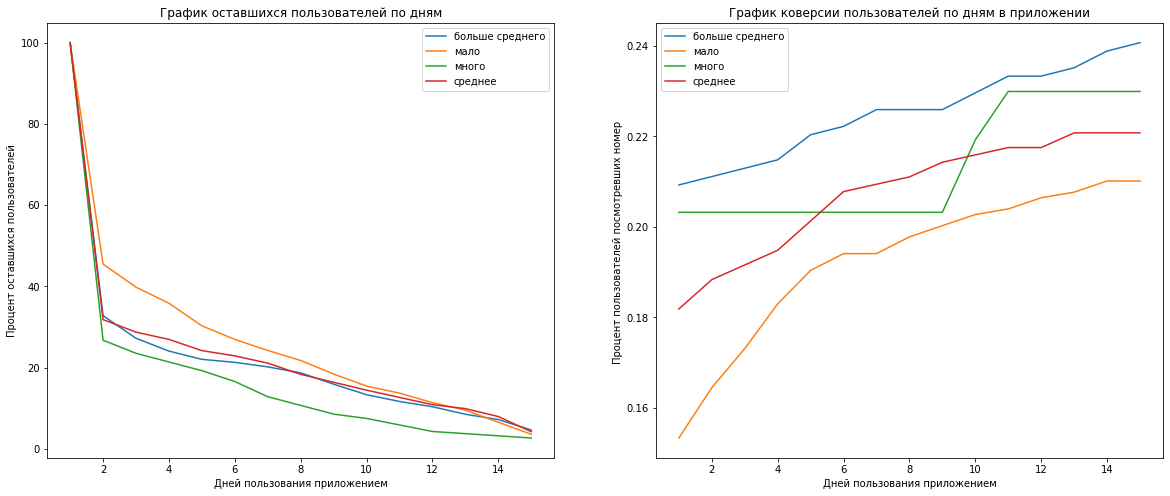

tips_show_true


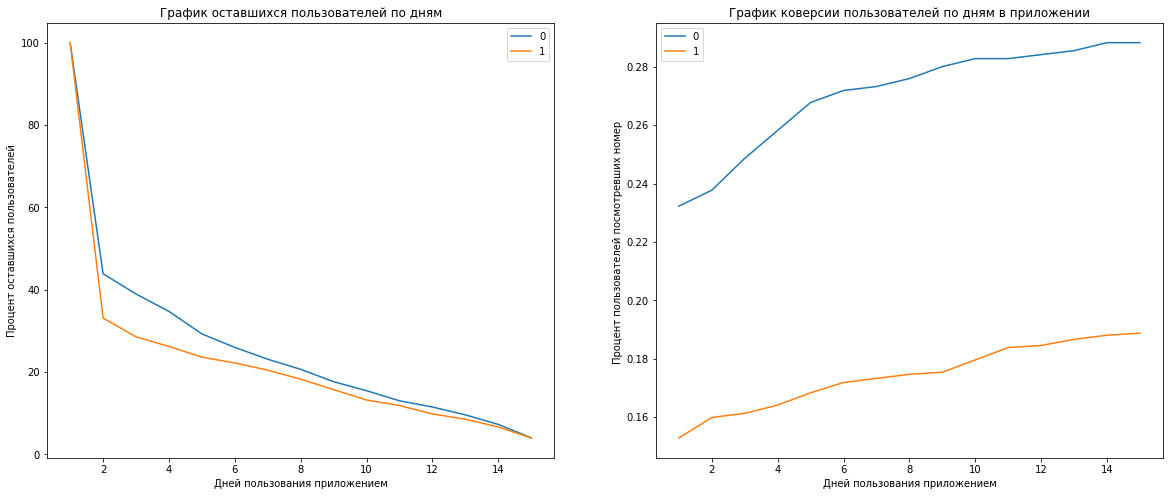

favorit_true


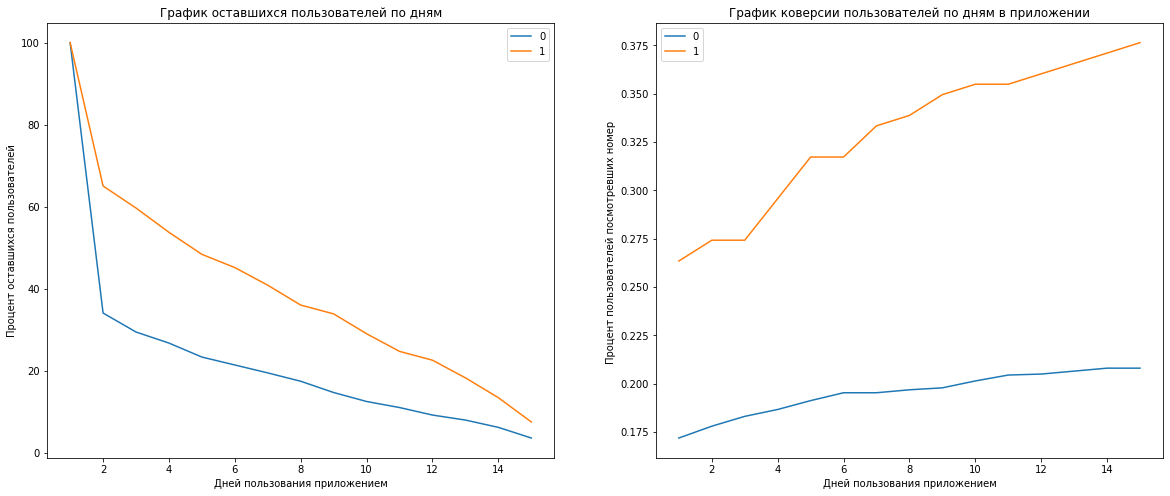

map_true


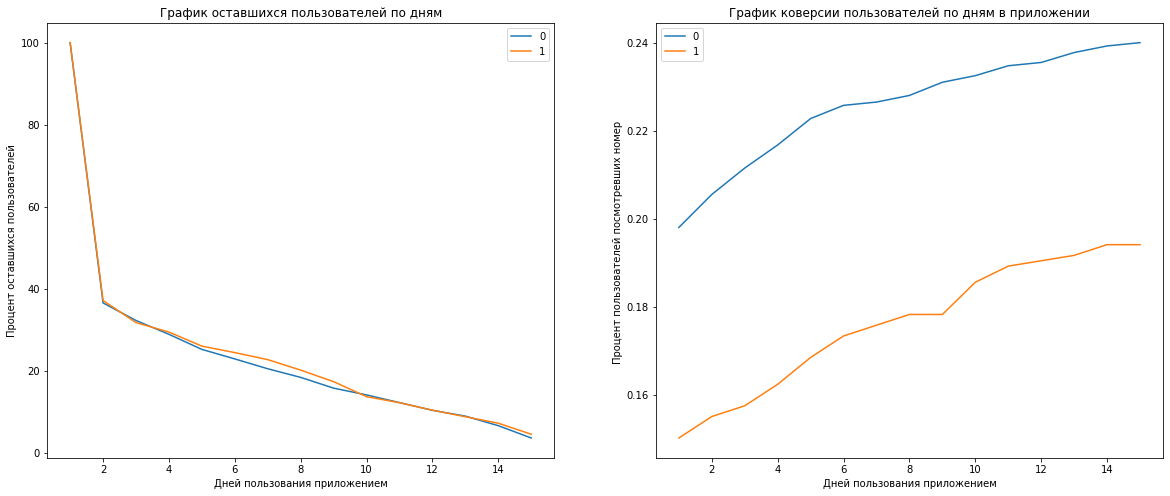

contacts_show_true


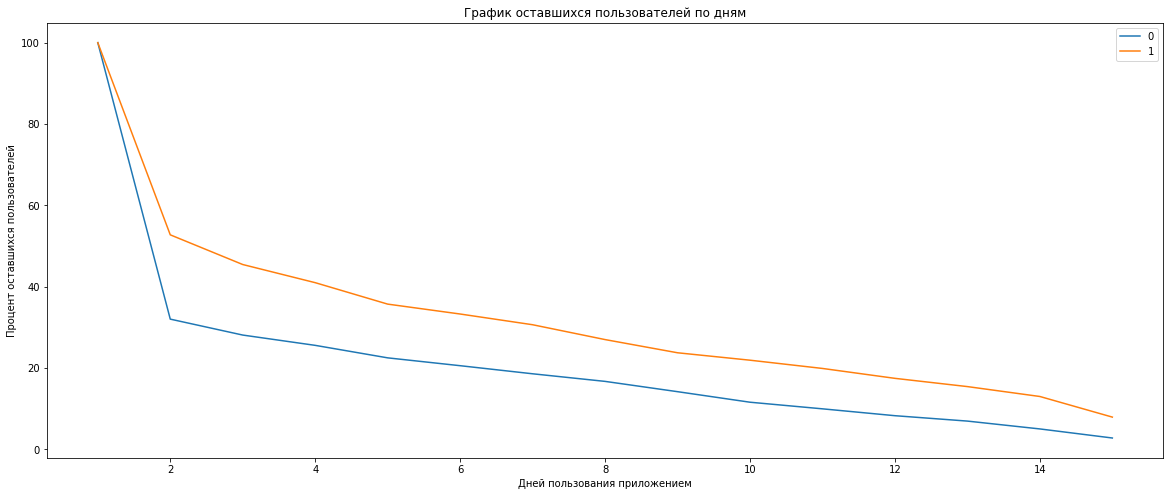

In [115]:
signs = ['first_dt', 'source','session_group','action_group','tips_show_true','favorit_true', 'map_true','contacts_show_true']
for sign in signs:
    print(sign)
    try:
        ret_con_watch(ss,sign)
    except:
        ret_watch(ss,sign)

- По дням отток пользователей и конверсия не сильно отличается, можно отметить что основной отток пользователей происходит на первые вторые дни.
- По ресурсу, с которого приходят пользователи отток у всех пользователей аналогичный, основное падение происходит на первые и вторые сутки, по уровню конверсии лидирует Яндекс, но рост конверсии по всем ресурсам пропорциональный.
- По частоте сессий, видна наглядная зависимость, что при увеличении количества сессий, отток у пользователей существенно уменьшается, и конверсия сильно увеличивается, у пользователей, которые редко заходят, конверсия низкая, и с первого дня, почти не повышается.
- По количеству действий в одну сессию, тот кто делает мало действий в сессию, имеет самый низкий отток, но и самую низкую конверсию. Пользователи, которые делают в сессию очень много действий на сайте, имеют самый большой отток и среднюю конверсию, лучше всего себя показывают пользователи, которые совершают действий за сессию, немного больше среднего.
- По, пользователям которым показывалось и не показывались рекомендации, лучше себя показывают пользователи, которым рекомендации не показывались, у них ниже отток в первые дни (на 14 день график сравнивается) и выше показатель и динамика конверсии
- Пользователи, которые добавляют товар избранное, свойственен меньший отток, и у них заметно выше показатель конверсии
- Пользователи, которые не открывали карту размещения объявлений, имеют более высокую конверсию.
- Пользователи, которые используют функцию, просмотр контакта, имеют меньший отток из приложения. 




##### Посмотрим на изспользование фукции просмотра номера по группа пользователей до и после использования использования в приложении навигации map

In [116]:
map_df = map_df.rename(columns={'user_id_x': 'user_id'})

In [117]:
map_df['first_dt'] = map_df['first_dt'].dt.date
map_df['lifetime'] = map_df['lifetime'].dt.days

In [118]:
map_df.query('use_map == "before"').groupby('user_id')['lifetime'].max().mean()

0.9198767334360555

In [119]:
map_df.query('use_map == "after"').groupby('user_id')['lifetime'].max().mean()

2.7740384615384617

In [120]:
print('Процент пользователей посмотревшие номер до использования функциий map: ',\
      np.round((map_df.query('use_map == "before"').groupby('user_id')['event_contacts_show'].max().mean())*100), '%')

Процент пользователей посмотревшие номер до использования функциий map:  11.0 %


In [121]:
print('Процент пользователей посмотревшие номер после использования функциий map: ',\
      np.round((map_df.query('use_map == "after"').groupby('user_id')['event_contacts_show'].max().mean())*100), '%')

Процент пользователей посмотревшие номер после использования функциий map:  17.0 %


##### Посмотрим выполнение целевого действия  по группе пользователей до и после использования показа им рекомендаций

In [122]:
tip_df['first_dt'] = tip_df['first_dt'].dt.date
tip_df['lifetime'] = tip_df['lifetime'].dt.days
tip_df = tip_df.rename(columns={'user_id_x': 'user_id'})


In [123]:
tip_df.query('show_tip == "before"').groupby('user_id')['lifetime'].max().mean()

0.14682822523164646

In [124]:
tip_df.query('show_tip == "after"').groupby('user_id')['lifetime'].max().mean()

2.258479114601928

In [125]:
print('Процент пользователей посмотревшие номер до показа рекомендаций: ',\
      np.round((tip_df.query('show_tip == "before"').groupby('user_id')['event_contacts_show'].max().mean())*100), '%')

Процент пользователей посмотревшие номер до показа рекомендаций:  4.0 %


In [126]:
print('Процент пользователей посмотревшие номер после показа рекомендаций: ',\
      np.round((tip_df.query('show_tip == "after"').groupby('user_id')['event_contacts_show'].max().mean())*100), '%')

Процент пользователей посмотревшие номер после показа рекомендаций:  18.0 %


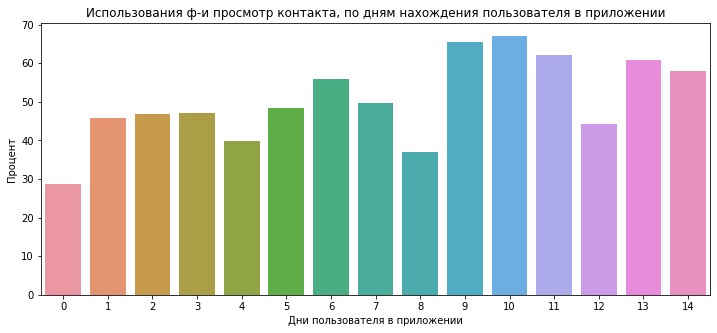

In [127]:
lf_contacts_show = (ss.groupby('lifetime')['contacts_show_true'].mean()*100).reset_index()


plt.figure(figsize=(12,5))
sns.barplot(x='lifetime',y='contacts_show_true', data=lf_contacts_show)
plt.title('Использования ф-и просмотр контакта, по дням нахождения пользователя в приложении')
plt.xlabel('Дни пользователя в приложении')
plt.ylabel('Процент')

plt.show()


- Анализ пользователей по на до и после использования функции map и показа рекомендации, показал, что пользорватели чаще открывали номер после выполнения данных действий. Данный анализ не сильно объективен, так как пользователи склонны совершать целевое действие(просмотр контакта), не в первые в а вследующие дни, а большинство пользователей до этотого времени уже используют навигацию по сайту и видят рекомендованные объявления. Более объяктивные наблюдения когда сравниваются группы, не использовавшие навигации по сайту, и не видевшие рекомендации, показывают лучшую конверсию 

In [128]:
ses_grp = df.groupby('session_group').agg(
    {'contacts_show_true' : 'mean', 'tips_show_true' : 'mean', 'favorit_true' : 'mean', 'map_true' : 'mean'}).reset_index()
ses_grp.columns = ['На сколько часто у группы сессии', 'Процент показа номера' ,'Процент показа рекомендаций','Процент добавления в избранное','Процент открытия карты объявлений']

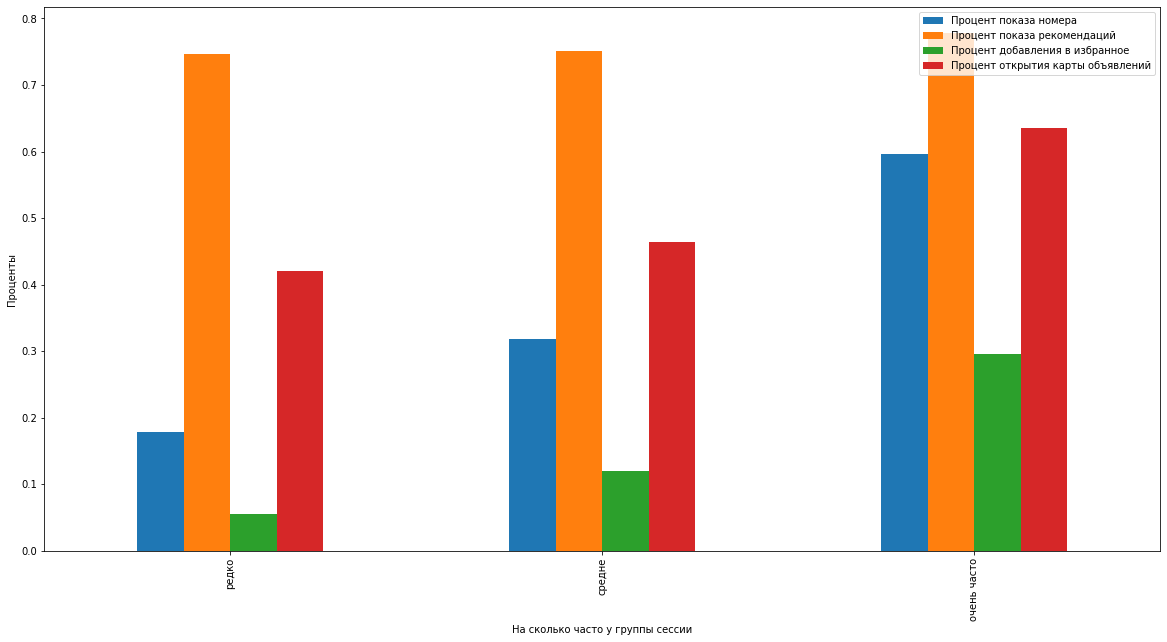

In [129]:
ses_grp.plot.bar(x='На сколько часто у группы сессии', y=['Процент показа номера' ,'Процент показа рекомендаций','Процент добавления в избранное','Процент открытия карты объявлений'], figsize=(20,10))
plt.ylabel('Проценты')
plt.show()

- Пользователям в зависимости от количества сессий, показывается в одинаковом процентном соотношении рекомендации
- При большем количестве сессий пользователи чаще добавляют в избранное, чаще используют функцию map, и чаще выполняют целевое действие (посмотреть номер).

(Добавления по согласно кометарию)

In [130]:
sdf = df.copy()

In [131]:
sdf['search'] = (sdf['event_name'].isin(['search_1','search_2','search_3','search_4','search_5','search_6','search_7']))*1

In [132]:
search_use = sdf.query('search == 1').sort_values(by='event_time')\
.groupby('user_id').agg({'event_time' : 'first', 'first_dt':'first'})

search_use['time_pass_d'] = (search_use.event_time - search_use.first_dt).dt.days
search_use['time_pass_h'] = ((search_use.event_time - search_use.first_dt).dt.days * 24) +\
(((search_use.event_time - search_use.first_dt).dt.seconds) / (60))  



In [133]:
(search_use.event_time == search_use.first_dt).sum() / search_use.event_time.count()

0.6962785114045619

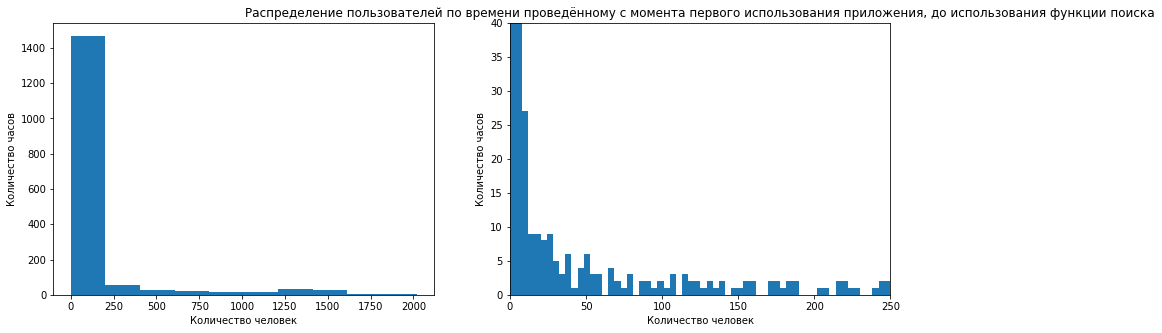

In [134]:

ax1 = plt.subplot(1,2,1)
search_use.time_pass_h.plot(kind='hist',  figsize=(15,5), ax=ax1)
plt.xlabel('Количество человек')
plt.ylabel('Количество часов')
ax2 = plt.subplot(1,2,2)
plt.title('Распределение пользователей по времени проведённому с момента первого использования приложения, до использования функции поиска')
search_use.time_pass_h.plot(kind='hist', bins=500, ylim = (0,40), xlim = (0,250), ax=ax2)
plt.xlabel('Количество человек')
plt.ylabel('Количество часов')
plt.show()
# plt.figure(figsize=(20,20))
# plt.xlim(0,5)

- В большинстве случаев из пользователей, кто пользовался поиском, использовали поиск в первую сессию с первого захода на сайт, таких пользователей набралось более 69 процентов, пользователи, которые воспользовались функцией поиска не сразу, многие ис пользователей не пользовались функцией поиска вообще

# 5. Проверка гипотезы

Проверим гиппотезу о том, что пользователям которым показывались рекомендованные сообщения, реже нажимали на просмотр контакта
Н0 - нулевая гипотеза состоит в том, что группы одинаковые
Н1 - альтернативная гипотеза состоит в том, что группы различны

In [135]:
tips_show_table = df.groupby('user_id', as_index=False).agg({'tips_show_true':'first', 'contacts_show_true' : 'first'})\
.pivot_table(index='tips_show_true', values='contacts_show_true', aggfunc=['count', 'sum'])
tips_show_table.columns = ['count_all', 'sum_all']
tips_show_table['converse'] = (tips_show_table.sum_all / tips_show_table.count_all)*100
tips_show_table

,count_all,sum_all,converse
tips_show_true,,,
0,1492,465,31.166220
1,2801,516,18.421992


In [136]:
alpha = .05 # критический уровень статистической значимости
successes = np.array([tips_show_table.values[0,1], tips_show_table.values[1,1]])
trials = np.array([tips_show_table.values[0,0], tips_show_table.values[1,0]])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]
# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]
# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 


p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Как показал статистический тест, между долями которым показывались и не показывались рекомендации есть статистическая значимость. У групп которым, рекомендации не показывались конверсия выше и составляет 31% против 18%, когда рекомендации показывались

Проверим гиппотезу о том, что пользователи из Яндекса и с Гугл демонстрируют разную конверсию в просмотры контактов
Н0 - нулевая гипотеза состоит в том, что группы одинаковые
Н1 - альтернативная гипотеза состоит в том, что группы различны

In [137]:
df.head(1)

,event_time,event_name,user_id,source,first_dt,lifetime,session,user_session,action,session_group,action_group,contacts_show_count,contacts_show_true,event_contacts_show,tips_show_true,event_tips_show,favorit_true,map_true,event_map
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:45.989359,0 days,1,1,1,средне,среднее,0.0,0,0,1,1,0,1,0


In [138]:
source_table = df.groupby('user_id', as_index=False).agg({'source':'first', 'contacts_show_true' : 'first'})\
.pivot_table(index='source', values='contacts_show_true', aggfunc=['count', 'sum']).reset_index()
source_table.columns = ['source', 'count_all', 'sum_all']
source_table['converse'] = (source_table.sum_all / source_table.count_all)*100
source_table = source_table.drop(source_table[source_table['source'] == 'other'].index).reset_index(drop=True)
source_table.index = source_table.source
source_table.pop('source')

source_table

,count_all,sum_all,converse
source,,,
google,1129,275,24.357839
yandex,1934,478,24.715615


In [139]:
alpha = .05 # критический уровень статистической значимости
successes = np.array([source_table.values[0,1], source_table.values[1,1]])
trials = np.array([source_table.values[0,0], source_table.values[1,0]])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]
# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]
# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


На основании проведённого статистического теста, на не удалось опровергнуть нулевую теорию о том, что конверсия пользователей яндекса и Гугл различна

# Вывод

- Данные коректны в плане совпадения таблиц mobile_sourсes,  mobile_dataset
- Отсутствующих значений не было обнаружено, дубликатов нет
- Предоставлена выборка за 28 дней
- В большинстве случаев пользователи приходят с яндекса, с гугла приходит меньше примерно в 1.5 раза,с остальных ресурсов вместе взятых приходит примерно столько же как с гугла
- По частоте событий, лидирует tips_show, потом идёт photos_show, затем advert_open и contacts_show 
- Достаточно редки события tips_click, contacts_call, favorites_add, все события search (кроме search_1)

Самые частые сессии:
1. Показанные рекомендации
2. Посмотр фотографий в объявлении
3. Показанные рекомендаци + открытие карты объявлений 
 - в сессии в которых показывался контакт можно выделить, что пользователи чаще на 1,5 процентра нажимали на рекомендованные объявления и чаще добавляли в избранное в 1,5 раза.
 - так же можно отметить в сессии где совершался просмотр контакта, остальных действий совершалось меньше
 - самое болшое количество действий в сессию в среднем в сессиях где выполнялось целевое действие 
- количество пользователей совершивших целевые действия у гугла и яндекса больше чем с остальных ресурсов и одинаков, но с гугла пользователь в среднем больше совершает целевых действий. 
- Пользователи у которых мало сессий совершают чаще целевое действие в первую сессию
- Пользователи у которых 3-5 сессий чаще совершают целевое действие на 3 сессию
- Пользователи с большим количеством сессий совершают больше целевых действий по мере роста сессий до 38
- целевое событие может совершаться как и сначало сессии так и ближе концу (зависимости нет)
- группа которая совершала целевое действие, чаще добавляла товар в избранное (но отличие не сильно существенное)
- группа которая совершала целевое действие, чаще смотрела фотографии (но фотографии чаще просматривались не в ту сессию когда совершлось целевое действие)
- группа которая совершала целевое действие, чаще нажимала на просмотр рекомендации (данное действие чаще совершалось в момент совершения целевого действия)
- группа которая несовершала целевое действие больше всего видела рекомендаций
- по зависимости показа рекомендательных объявлений видим, что группа которым объявление показывалось реже выполняли целевое действие.
- группа которым не показывались рекомендованные объявления так же, намного чаще смотрят фотографии, и выполняет в среднем меньше действий
- самое большое количество целевых действий у яндекса, данный показатель достиг такого уровня за счёт самой большой аудитории у сервиса. 
- у гугл большу средних количеств действий по группе у которых много сессий, за счёт данного показателя у гугл лучше общие показатели по количеству целевых действий на одного человека
- По дням отток пользователей и конверсия не сильно отличается, можно отметить что основной отток пользователей происходит на первые вторые дни.
- По ресурсу, с которого приходят пользователи отток у всех пользователей аналогичный, основное падение происходит на первые и вторые сутки, по уровню конверсии лидирует Яндекс, но рост конверсии по всем ресурсам пропорциональный.
- По частоте сессий, видна наглядная зависимость, что при увеличении количества сессий, отток у пользователей существенно уменьшается, и конверсия сильно увеличивается, у пользователей, которые редко заходят, конверсия низкая, и с первого дня, почти не повышается.
- По количеству действий в одну сессию, тот кто делает мало действий в сессию, имеет самый низкий отток, но и самую низкую конверсию. Пользователи, которые делают в сессию очень много действий на сайте, имеют самый большой отток и среднюю конверсию, лучше всего себя показывают пользователи, которые совершают действий за сессию, немного больше среднего.
- По, пользователям которым показывалось и не показывались рекомендации, лучше себя показывают пользователи, которым рекомендации не показывались, у них ниже отток в первые дни (на 14 день график сравнивается) и выше показатель и динамика конверсии
- Пользователи, которые добавляют товар избранное, свойственен меньший отток, и у них заметно выше показатель конверсии
- Пользователи, которые не открывали карту размещения объявлений, имеют более высокую конверсию.
- Пользователи, которые используют функцию, просмотр контакта, имеют меньший отток из приложения. 
- Анализ пользователей по на до и после использования функции map и показа рекомендации, показал, что пользорватели чаще открывали номер после выполнения данных действий. Данный анализ не сильно объективен, так как пользователи склонны совершать целевое действие(просмотр контакта), не в первые в а вследующие дни, а большинство пользователей до этотого времени уже используют навигацию по сайту и видят рекомендованные объявления. Более объяктивные наблюдения когда сравниваются группы, не использовавшие навигации по сайту, и не видевшие рекомендации, показывают лучшую конверсию 
- Пользователям в зависимости от количества сессий, показывается в одинаковом процентном соотношении рекомендации
- При большем количестве сессий пользователи чаще добавляют в избранное, чаще используют функцию map, и чаще выполняют целевое действие (посмотреть номер).
- Cтатистический тест показал, между долями которым показывались и не показывались рекомендации есть статистическая значимость. У групп которым, рекомендации не показывались конверсия выше и составляет 31% против 18%, когда рекомендации показывались

- В большинстве случаев из пользователей, кто пользовался поиском, использовали поиск в первую сессию с первого захода на сайт, таких пользователей набралось более 69 процентов, пользователи, которые воспользовались функцией поиска не сразу, многие ис пользователей не пользовались функцией поиска вообще
- На основании проведённого статистического теста, на не удалось опровергнуть нулевую теорию о том, что конверсия пользователей яндекса и Гугл различна

Рекомендации: 1. Поправить рекомендательную систему приложения. 2. Сделать события более прослеживаемы (от первого захода, до целевого действия), это поможет выстроить воронку, и анализировать на каком этапе отваливаются пользователи. 3. Хорошо, было бы ещё собирать данные пользователя, для создания его покупательского профиля. 